# State Task Networks

This notebook implements in Pyomo the state task network described in Section 3 of Kondili, Pantelides & Sargent (1993).

In [1]:
from pyomo.environ import *
import itertools

In [2]:
model = ConcreteModel()

# Notation

The time discretisation is defined by

In [3]:
model.H = 10
model.T = Set(initialize=RangeSet(0, model.H + 1), doc='Time Periods')
model.T.pprint()

T : Time Periods
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   12 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


States, tasks and units are defined by

In [4]:
model.States = Set(
    initialize=['Feed A', 'Feed B', 'Feed C', 'Hot A', 'Int BC', 'Int AB',
                'Impure E', 'Product 1', 'Product 2'], doc='States')
model.I = Set(initialize=['Heating', 'Reaction 1', 'Reaction 2', 'Reaction 3', 'Separation'], doc='Tasks')
model.J = Set(initialize=['Heater', 'Reactor 1', 'Reactor 2', 'Still'], doc='Units')

## Task definition

Task $i$ is defined by indexed sets, but we cannot initialize parameters or variables by indexed sets in Pyomo so we use an indexed set and tuples. We could just use the map directly, but it may be easier to specify the index set for the GUI. The user defines the index set and then `mola` builds the tuples.

In [5]:
map_S_I = {
    'Heating': ['Feed A'],
    'Reaction 1': ['Feed B', 'Feed C'],
    'Reaction 2': ['Hot A', 'Int BC'],
    'Reaction 3': ['Int AB', 'Feed C'],
    'Separation': ['Impure E']
}
model.SI = Set(model.I, initialize=map_S_I, within=model.States)
model.S_I = Set(within=model.States * model.I, initialize=[(s, i) for i in model.I for s in model.SI[i]], 
                doc='States that feed task i')
model.S_I.pprint()

S_I : States that feed task i
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : S_I_domain :    8 : {('Feed A', 'Heating'), ('Feed B', 'Reaction 1'), ('Feed C', 'Reaction 1'), ('Hot A', 'Reaction 2'), ('Int BC', 'Reaction 2'), ('Int AB', 'Reaction 3'), ('Feed C', 'Reaction 3'), ('Impure E', 'Separation')}


In [6]:
map_S_bar_I = {
    'Heating': ['Hot A'],
    'Reaction 1': ['Int BC'],
    'Reaction 2': ['Product 1', 'Int AB'],
    'Reaction 3': ['Impure E'],
    'Separation': ['Product 2', 'Int AB']
}
model.S_barI = Set(model.I, initialize=map_S_bar_I, within=model.States)
model.S_bar_I = Set(within=model.States * model.I, initialize=[(s, i) for i in model.I for s in model.S_barI[i]],
                   doc='States produced by task i')
model.S_bar_I.pprint()

S_bar_I : States produced by task i
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain         : Size : Members
    None :     2 : S_bar_I_domain :    7 : {('Hot A', 'Heating'), ('Int BC', 'Reaction 1'), ('Product 1', 'Reaction 2'), ('Int AB', 'Reaction 2'), ('Impure E', 'Reaction 3'), ('Product 2', 'Separation'), ('Int AB', 'Separation')}


In [7]:
map_rho = {
    ('Feed A', 'Heating'): 1,
    ('Feed B', 'Reaction 1'): 0.5,
    ('Feed C', 'Reaction 1'): 0.5,
    ('Hot A', 'Reaction 2'): 0.4,
    ('Int BC', 'Reaction 2'): 0.6,
    ('Feed C', 'Reaction 3'): 0.2,
    ('Int AB', 'Reaction 3'): 0.8,
    ('Impure E', 'Separation'): 1
}
model.rho = Param(model.S_I, initialize=map_rho, doc='Proportion of input of task i from state s')
model.rho.pprint()

rho : Proportion of input of task i from state s
    Size=8, Index=S_I, Domain=Any, Default=None, Mutable=False
    Key                        : Value
         ('Feed A', 'Heating') :     1
      ('Feed B', 'Reaction 1') :   0.5
      ('Feed C', 'Reaction 1') :   0.5
      ('Feed C', 'Reaction 3') :   0.2
       ('Hot A', 'Reaction 2') :   0.4
    ('Impure E', 'Separation') :     1
      ('Int AB', 'Reaction 3') :   0.8
      ('Int BC', 'Reaction 2') :   0.6


In [8]:
map_rho_bar = {
    ('Hot A', 'Heating'): 1,
    ('Int BC', 'Reaction 1'): 1,
    ('Product 1', 'Reaction 2'): 0.4,
    ('Int AB', 'Reaction 2'): 0.6,
    ('Impure E', 'Reaction 3'): 1,
    ('Product 2', 'Separation'): 0.9,
    ('Int AB', 'Separation'): 0.1
}
model.rho_bar = Param(model.S_bar_I, initialize=map_rho_bar,
                      doc='Proportion of output of task i to state s')
model.rho_bar.pprint()

rho_bar : Proportion of output of task i to state s
    Size=7, Index=S_bar_I, Domain=Any, Default=None, Mutable=False
    Key                         : Value
           ('Hot A', 'Heating') :     1
     ('Impure E', 'Reaction 3') :     1
       ('Int AB', 'Reaction 2') :   0.6
       ('Int AB', 'Separation') :   0.1
       ('Int BC', 'Reaction 1') :     1
    ('Product 1', 'Reaction 2') :   0.4
    ('Product 2', 'Separation') :   0.9


In [9]:
map_P = {
    ('Hot A', 'Heating'): 1,
    ('Int BC', 'Reaction 1'): 2,
    ('Product 1', 'Reaction 2'): 2,
    ('Int AB', 'Reaction 2'): 2,
    ('Impure E', 'Reaction 3'): 1,
    ('Product 2', 'Separation'): 1,
    ('Int AB', 'Separation'): 2
}
model.P = Param(model.S_bar_I, initialize=map_P, 
                doc='Processing time for the output of task i to state s')
model.P.pprint()

P : Processing time for the output of task i to state s
    Size=7, Index=S_bar_I, Domain=Any, Default=None, Mutable=False
    Key                         : Value
           ('Hot A', 'Heating') :     1
     ('Impure E', 'Reaction 3') :     1
       ('Int AB', 'Reaction 2') :     2
       ('Int AB', 'Separation') :     2
       ('Int BC', 'Reaction 1') :     2
    ('Product 1', 'Reaction 2') :     2
    ('Product 2', 'Separation') :     1


In [10]:
def p_rule(model, i):
    return max(model.P[s, i] for s in model.S_barI[i])
model.p = Param(model.I, initialize=p_rule, doc='Completion time for task i')
model.p.pprint()

p : Completion time for task i
    Size=5, Index=I, Domain=Any, Default=None, Mutable=False
    Key        : Value
       Heating :     1
    Reaction 1 :     2
    Reaction 2 :     2
    Reaction 3 :     1
    Separation :     2


In [11]:
model.J.pprint()

J : Units
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    4 : {'Heater', 'Reactor 1', 'Reactor 2', 'Still'}


In [12]:
map_K_I = {
    'Heating': ['Heater'],
    'Reaction 1': ['Reactor 1', 'Reactor 2'],
    'Reaction 2': ['Reactor 1', 'Reactor 2'],
    'Reaction 3': ['Reactor 1', 'Reactor 2'],
    'Separation': ['Still']
}
model.KI = Set(model.I, initialize=map_K_I, within=model.J)
model.K_I = Set(within=model.J * model.I, initialize=[(j, i) for i in model.I for j in model.KI[i]], 
                doc='Units capable of performing task i')
model.K_I.pprint()

K_I : Units capable of performing task i
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : K_I_domain :    8 : {('Heater', 'Heating'), ('Reactor 1', 'Reaction 1'), ('Reactor 2', 'Reaction 1'), ('Reactor 1', 'Reaction 2'), ('Reactor 2', 'Reaction 2'), ('Reactor 1', 'Reaction 3'), ('Reactor 2', 'Reaction 3'), ('Still', 'Separation')}


## State definition

The set $T_s$ is the set of tasks that receive material from state $s$. It is the inversion of the set $S_i$.

In [13]:
map_T_S = {}
for s, i in model.S_I:
    map_T_S.setdefault(s, []).append(i)

map_T_S

{'Feed A': ['Heating'],
 'Feed B': ['Reaction 1'],
 'Feed C': ['Reaction 1', 'Reaction 3'],
 'Hot A': ['Reaction 2'],
 'Int BC': ['Reaction 2'],
 'Int AB': ['Reaction 3'],
 'Impure E': ['Separation']}

The `setdefault` method for a dict ensures that we append to an empty list if the state does not yet exist in `map_T_S`. 

In [14]:
model.TS = Set(model.States, initialize=map_T_S, within=model.I)
model.T_S = Set(within=model.I * model.States, 
                initialize=[(i, s) for s in model.TS.keys() for i in model.TS[s]], 
                doc='Tasks receiving material from state s')
model.T_S.pprint()

T_S : Tasks receiving material from state s
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : T_S_domain :    8 : {('Heating', 'Feed A'), ('Reaction 1', 'Feed B'), ('Reaction 1', 'Feed C'), ('Reaction 3', 'Feed C'), ('Reaction 2', 'Hot A'), ('Reaction 2', 'Int BC'), ('Reaction 3', 'Int AB'), ('Separation', 'Impure E')}


The set $\bar{T}_s$ is the set of tasks that produce material in state $s$.

In [15]:
map_T_bar_S = {}
for s, i in model.S_bar_I:
    map_T_bar_S.setdefault(s, []).append(i)

map_T_bar_S

{'Hot A': ['Heating'],
 'Int BC': ['Reaction 1'],
 'Product 1': ['Reaction 2'],
 'Int AB': ['Reaction 2', 'Separation'],
 'Impure E': ['Reaction 3'],
 'Product 2': ['Separation']}

In [16]:
model.T_barS = Set(model.States, initialize=map_T_bar_S, within=model.I)
model.T_bar_S = Set(within=model.I * model.States, 
                    initialize=[(i, s) for s in model.T_barS for i in model.T_barS[s]],
                    doc='Tasks producing material in state s')
model.T_bar_S.pprint()

T_bar_S : Tasks producing material in state s
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain         : Size : Members
    None :     2 : T_bar_S_domain :    7 : {('Heating', 'Hot A'), ('Reaction 1', 'Int BC'), ('Reaction 2', 'Int AB'), ('Separation', 'Int AB'), ('Reaction 3', 'Impure E'), ('Reaction 2', 'Product 1'), ('Separation', 'Product 2')}


In [17]:
map_C = {
    'Feed A': float('inf'), 'Feed B': float('inf'), 'Feed C': float('inf'),
    'Hot A': 100, 'Int BC': 150, 'Int AB': 200, 'Impure E': 100,
    'Product 1': float('inf'), 'Product 2': float('inf')}
model.C = Param(model.States, initialize=map_C, doc='Maximum storage capacity dedicated to state s')
model.C.pprint()

C : Maximum storage capacity dedicated to state s
    Size=9, Index=States, Domain=Any, Default=None, Mutable=False
    Key       : Value
       Feed A :   inf
       Feed B :   inf
       Feed C :   inf
        Hot A :   100
     Impure E :   100
       Int AB :   200
       Int BC :   150
    Product 1 :   inf
    Product 2 :   inf


## Unit definition

The set $I_j$ is the set of tasks that can be performed by unit $j$. It is the inversion of the set $K_i$.

In [18]:
map_I_J = {}
for j, i in model.K_I:
    map_I_J.setdefault(j, []).append(i)

In [19]:
model.IJ = Set(model.J, initialize=map_I_J, within=model.I)
model.I_J = Set(within=model.I * model.J, initialize=[(i, j) for j in model.J for i in model.IJ[j]],
                doc='Tasks that can be performed by unit j')
model.I_J.pprint()

I_J : Tasks that can be performed by unit j
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : I_J_domain :    8 : {('Heating', 'Heater'), ('Reaction 1', 'Reactor 1'), ('Reaction 2', 'Reactor 1'), ('Reaction 3', 'Reactor 1'), ('Reaction 1', 'Reactor 2'), ('Reaction 2', 'Reactor 2'), ('Reaction 3', 'Reactor 2'), ('Separation', 'Still')}


In [20]:
model.I_J.pprint()

I_J : Tasks that can be performed by unit j
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain     : Size : Members
    None :     2 : I_J_domain :    8 : {('Heating', 'Heater'), ('Reaction 1', 'Reactor 1'), ('Reaction 2', 'Reactor 1'), ('Reaction 3', 'Reactor 1'), ('Reaction 1', 'Reactor 2'), ('Reaction 2', 'Reactor 2'), ('Reaction 3', 'Reactor 2'), ('Separation', 'Still')}


In [21]:
map_V_max = {
    ('Heating', 'Heater'): 100,
    ('Reaction 1', 'Reactor 1'): 80,
    ('Reaction 2', 'Reactor 1'): 80,
    ('Reaction 3', 'Reactor 1'): 80,
    ('Reaction 1', 'Reactor 2'): 50,
    ('Reaction 2', 'Reactor 2'): 50,
    ('Reaction 3', 'Reactor 2'): 50,
    ('Separation', 'Still'): 200
}
map_V_min = {
    ('Heating', 'Heater'): 0,
    ('Reaction 1', 'Reactor 1'): 0,
    ('Reaction 2', 'Reactor 1'): 0,
    ('Reaction 3', 'Reactor 1'): 0,
    ('Reaction 1', 'Reactor 2'): 0,
    ('Reaction 2', 'Reactor 2'): 0,
    ('Reaction 3', 'Reactor 2'): 0,
    ('Separation', 'Still'): 0
}
model.V_max = Param(model.I_J, initialize=map_V_max, 
                    doc='Maximum capacity of unit j when used for performing task i')
model.V_min = Param(model.I_J, initialize=map_V_min, 
                    doc='Minimum capacity of unit j when used for performing task i')

# Variables

In [22]:
model.W = Var(model.I_J, model.T, doc='Start task k using unit j at time t', within=Binary)

In [23]:
model.B = Var(model.I_J, model.T,
              doc='Amount of material which starts undergoing task i in unit j at beginning of t', within=NonNegativeReals)

In [24]:
model.S = Var(model.States, model.T, 
              doc='Amount of material stored in state s at beginning of t', within=NonNegativeReals)

# Constraints

## Allocation Constraints

In [25]:
model.M = Param(initialize=1000, doc='Allocation constraint parameter')
def allocation_constraints_rule(model, i, j, t):
    lhs = sum(model.W[idash, j, tdash] for tdash in model.T for idash in model.IJ[j] 
              if tdash >= t and tdash <= t + model.p[i] - 1) - 1
    rhs = model.M * (1 - model.W[i, j, t])
    return lhs <= rhs
model.allocation_constraints = Constraint(model.I_J, model.T, rule=allocation_constraints_rule)

In [26]:
model.allocation_constraints['Separation', 'Still', 0].pprint()

{Member of allocation_constraints} : Size=96, Index=allocation_constraints_index, Active=True
    Key                        : Lower : Body                                                                                 : Upper : Active
    ('Separation', 'Still', 0) :  -Inf : W[Separation,Still,0] + W[Separation,Still,1] - 1 - 1000*(1 - W[Separation,Still,0]) :   0.0 :   True


Note that we use the indexed set `model.IJ` to sum over tasks for fixed unit $j$.

## Capacity Limitations

Why can't we use the `inequality` function here? It leads to an uninitialied NumericValue error when running the optimisation. The function is not well documented. It might be that it can only be used with a parameter in the lower or upper argument and the error is only shown at optimisation.

I have used two inequality constraints instead.

In [27]:
# def capacity_limitations_rule1(model, j, i, t):
#     return inequality(model.W[i, j, t] * model.V_min[i, j], model.B[i, j, t], model.W[i, j, t] * model.V_max[i, j]) 
# model.capacity_limitations1 = Constraint(model.K_I, model.T, rule=capacity_limitations_rule1)
def capacity_limitations_rule1a(model, j, i, t):
    return model.W[i, j, t] * model.V_min[i, j] <= model.B[i, j, t]
model.capacity_limitations1a = Constraint(model.K_I, model.T, rule=capacity_limitations_rule1a)
def capacity_limitations_rule1b(model, j, i, t):
    return model.B[i, j, t] <= model.W[i, j, t] * model.V_max[i, j]
model.capacity_limitations1b = Constraint(model.K_I, model.T, rule=capacity_limitations_rule1b)

We can use `inequality` here because `model.C` is a parameter.

In [28]:
def capacity_limitations_rule2(model, s, t):
    return inequality(0, model.S[s, t], model.C[s]) 
model.capacity_limitations2 = Constraint(model.States, model.T, rule=capacity_limitations_rule2)
# def capacity_limitations_rule2a(model, s, t):
#     return 0 <= model.S[s, t] 
# model.capacity_limitations2a = Constraint(model.States, model.T, rule=capacity_limitations_rule2a)
# def capacity_limitations_rule2b(model, s, t):
#     return model.S[s, t] <= model.C[s] 
# model.capacity_limitations2b = Constraint(model.States, model.T, rule=capacity_limitations_rule2b)

## Material Balances

In [29]:
model.D = Param(model.States, model.T, initialize=0,
                   doc='Delivery of material in state s at time t')
model.R = Param(model.States, model.T, initialize=0,
                   doc='Receipt of material in state s at time t')

In [30]:
map_T_bar_S.keys()

dict_keys(['Hot A', 'Int BC', 'Product 1', 'Int AB', 'Impure E', 'Product 2'])

In [31]:
def material_balances_rule(model, s, t):
    if t > model.T.first():
        rhs = model.S[s, t-1]
        if s in map_T_bar_S.keys():
            rhs += sum(model.rho_bar[s, i] * model.B[i, j, t-model.P[s, i]] 
                       for i in model.T_barS[s] for j in model.KI[i] if t > model.P[s, i])
        if s in map_T_S.keys():
            rhs -= sum(model.rho[s, i] * model.B[i, j, t] for i in model.TS[s] for j in model.KI[i])    
        return model.S[s, t] == rhs + model.R[s, t] - model.D[s, t]
    else:
        return Constraint.Feasible
model.material_balances = Constraint(model.States, model.T, rule=material_balances_rule)

In [32]:
model.material_balances[('Product 2', 1)].pprint()
model.S['Product 2', 1].pprint()
model.B['Separation', 'Still', 0].pprint()
model.S['Impure E', 1].pprint()
model.material_balances[('Impure E', 1)].pprint()
model.B['Reaction 3', 'Reactor 2', 0].pprint()

{Member of material_balances} : Size=99, Index=material_balances_index, Active=True
    Key              : Lower : Body                            : Upper : Active
    ('Product 2', 1) :   0.0 : S[Product 2,1] - S[Product 2,0] :   0.0 :   True
{Member of S} : Amount of material stored in state s at beginning of t
    Size=108, Index=S_index
    Key              : Lower : Value : Upper : Fixed : Stale : Domain
    ('Product 2', 1) :     0 :  None :  None : False :  True : NonNegativeReals
{Member of B} : Amount of material which starts undergoing task i in unit j at beginning of t
    Size=96, Index=B_index
    Key                        : Lower : Value : Upper : Fixed : Stale : Domain
    ('Separation', 'Still', 0) :     0 :  None :  None : False :  True : NonNegativeReals
{Member of S} : Amount of material stored in state s at beginning of t
    Size=108, Index=S_index
    Key             : Lower : Value : Upper : Fixed : Stale : Domain
    ('Impure E', 1) :     0 :  None :  None : Fa

We fix the initial states using an equality constraint.

In [33]:
init_S = {
    'Feed A': 100, 'Feed B': 100, 'Feed C': 100,
     'Hot A': 0, 'Int BC': 0, 'Int AB': 0, 'Impure E': 0,
     'Product 1': 0, 'Product 2': 0
}
def initial_state_rule(model, s):   
        return model.S[s, 0] == init_S[s]

model.initial_states = Constraint(model.States, rule=initial_state_rule)
model.initial_states.pprint()

initial_states : Size=9, Index=States, Active=True
    Key       : Lower : Body           : Upper : Active
       Feed A : 100.0 :    S[Feed A,0] : 100.0 :   True
       Feed B : 100.0 :    S[Feed B,0] : 100.0 :   True
       Feed C : 100.0 :    S[Feed C,0] : 100.0 :   True
        Hot A :   0.0 :     S[Hot A,0] :   0.0 :   True
     Impure E :   0.0 :  S[Impure E,0] :   0.0 :   True
       Int AB :   0.0 :    S[Int AB,0] :   0.0 :   True
       Int BC :   0.0 :    S[Int BC,0] :   0.0 :   True
    Product 1 :   0.0 : S[Product 1,0] :   0.0 :   True
    Product 2 :   0.0 : S[Product 2,0] :   0.0 :   True


## Product deliveries and raw material receipts during the horizon

This modification is incorporated in the previous section.

## Temporary Unavailability of Equipment

We don't need this constraint for the example.

## Limited Availability of Utilities and Man-Power

We don't need this constraint for the example.

## Cleaning Equipment Items

We don't need this constraint for the example.

# Objective Function

The objective for the paper is the maximisation of profit.

In [34]:
model.States.pprint()

States : States
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    9 : {'Feed A', 'Feed B', 'Feed C', 'Hot A', 'Int BC', 'Int AB', 'Impure E', 'Product 1', 'Product 2'}


In [35]:
def cost_rule(model, s, t):
    if s in ['Feed A', 'Feed B', 'Feed C']:
        cost = 0
    elif s in ['Hot A', 'Int BC', 'Int AB', 'Impure E']:
        if t == model.T.last():
            cost = -1
        else:
            cost = 0
    elif s in ['Product 1', 'Product 2']:
        cost = 10
    return cost
model.Cost = Param(model.States, model.T, initialize=cost_rule,
                   doc='Unit price of material in state s at time t')

In [36]:
def profit_rule(model):
    value_products = sum(model.Cost[s, model.H+1] * model.S[s, model.H+1] +
              sum(model.Cost[s, t] * model.D[s, t] for t in range(1, model.H+1)) for s in model.States)
    return value_products
model.obj = Objective(rule=profit_rule, doc='Maximisation of Profit', sense=maximize)
model.obj.pprint()

obj : Maximisation of Profit
    Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : - S[Hot A,11] - S[Int BC,11] - S[Int AB,11] - S[Impure E,11] + 10*S[Product 1,11] + 10*S[Product 2,11]


# Solution

In [37]:
opt = SolverFactory("glpk")
results = opt.solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2440.34722222222
  Upper bound: 2440.34722222222
  Number of objectives: 1
  Number of constraints: 553
  Number of variables: 301
  Number of nonzeros: 1292
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 283
      Number of created subproblems: 283
  Error rc: 0
  Time: 0.17250490188598633
# ----------------------------------------------------------
#   Solution Information
# ----

In [38]:
import plotnine as pn
import mola.output as mo
import pandas as pd
import numpy as np

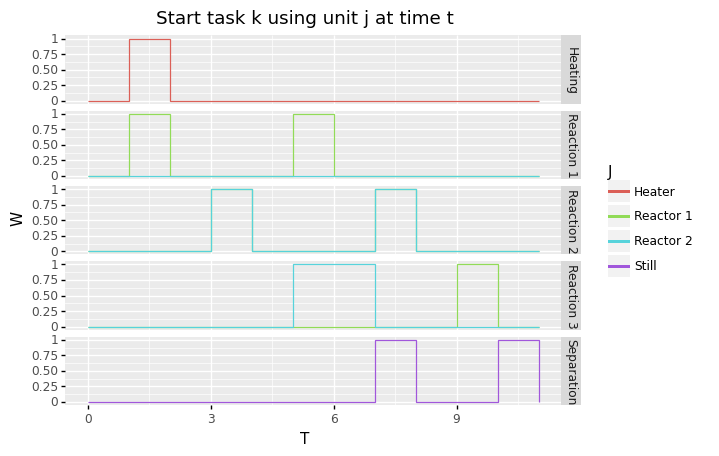

<ggplot: (8727780491913)>

In [39]:
W_df = mo.get_entity(model.W)
(pn.ggplot(W_df, pn.aes('T', 'W')) + pn.ggtitle(model.W.doc) +
 pn.geom_step(pn.aes(color='J'), direction='hv') +
 pn.facet_grid('I~'))

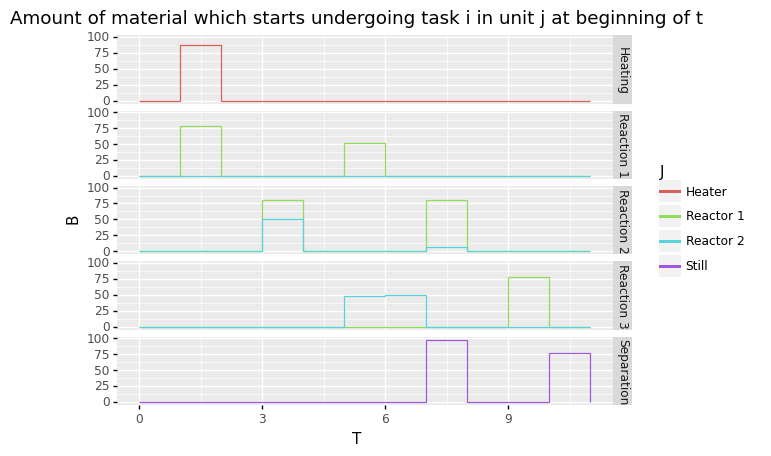

<ggplot: (8727758801053)>

In [40]:
B_df = mo.get_entity(model.B)
(pn.ggplot(B_df, pn.aes('T', 'B')) + pn.ggtitle(model.B.doc) +
 pn.geom_step(pn.aes(color='J'), direction='hv') +
 pn.facet_grid('I~'))

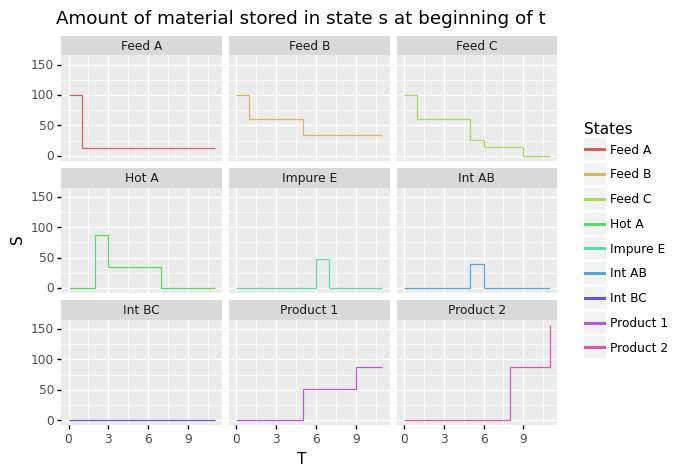

<ggplot: (8727758779273)>

In [41]:
S_df = mo.get_entity(model.S)
(pn.ggplot(S_df, pn.aes('T', 'S')) + pn.ggtitle(model.S.doc) +
 pn.geom_step(pn.aes(color='States'), direction='hv') +
 pn.facet_wrap('States'))

# Ports and Arcs

We try and solve the same problem using `pyomo` Ports and Arcs to represent the tasks, states, and their relationships. Can we get pyomo to generate the evolution of state equations as equality constraints?

Kantor has written a pyomo state task network package for pyomo - see https://jckantor.github.io/STN-Scheduler/.

It does not appear to use the built-in network module in pyomo though.

In [42]:
import pyomo.network as pn
pa_model = ConcreteModel()

Tasks have state inputs and state outputs.

In [44]:
print(map_S_I)
print(map_S_bar_I)

{'Heating': ['Feed A'], 'Reaction 1': ['Feed B', 'Feed C'], 'Reaction 2': ['Hot A', 'Int BC'], 'Reaction 3': ['Int AB', 'Feed C'], 'Separation': ['Impure E']}
{'Heating': ['Hot A'], 'Reaction 1': ['Int BC'], 'Reaction 2': ['Product 1', 'Int AB'], 'Reaction 3': ['Impure E'], 'Separation': ['Product 2', 'Int AB']}


States have task inputs and task outputs.

In [45]:
print(map_T_S)
print(map_T_bar_S)

{'Feed A': ['Heating'], 'Feed B': ['Reaction 1'], 'Feed C': ['Reaction 1', 'Reaction 3'], 'Hot A': ['Reaction 2'], 'Int BC': ['Reaction 2'], 'Int AB': ['Reaction 3'], 'Impure E': ['Separation']}
{'Hot A': ['Heating'], 'Int BC': ['Reaction 1'], 'Product 1': ['Reaction 2'], 'Int AB': ['Reaction 2', 'Separation'], 'Impure E': ['Reaction 3'], 'Product 2': ['Separation']}
